# Raman Signal Extraction from CARS Spectra Using a Learned-Matrix Representation of the Discrete Hilbert Transform

Charles H. Camp Jr.<br>
Biosystems and Biomaterials Division<br>
National Institute of Standards and Technology<br>
100 Bureau Dr., Gaithersburg, MD 20899<br>
[charles.camp@nist.gov](mailto:charles.camp@nist.gov?subject=Hilbert%20Python%20Package)

**This Jupyter Notebook recreates the figures in the LeDHT manuscript main section.**

# Imports, Class Definitions, and Bespoke Functions

In [1]:
from timeit import default_timer as timer
from copy import deepcopy

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size']=8
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['figure.figsize'] = (3,3)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['image.interpolation'] = 'None'
plt.rcParams['lines.linewidth'] = 0.5
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.borderpad'] = 0
plt.rcParams['legend.handlelength'] = 1.0
plt.rcParams['legend.handletextpad'] = 0.3
plt.rcParams['legend.labelspacing'] = 0
plt.rcParams['legend.columnspacing'] = 0.3
plt.rcParams['axes.labelpad'] = 0
plt.rcParams['axes.linewidth'] = 0.5

import matplotlib.gridspec as gridspec

cm = plt.cm.tab10
cm_steps = [0.2, 0.1, 0.0]
color_palette = [cm(c) for c in cm_steps]

import pandas as pd
import seaborn as sns

import h5py as h5

import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

from hilbert_toolkit import GaussianTrainingData, SyntheticSpectra, DHT, DHT_Pad, LeDHT
from hilbert_toolkit import hilbert_scipy as hilbert

## Utility Functions

In [2]:
def find_nearest(np_vec,to_find = 0):
    """
    Given a vector and a value (or list/vector of values), find the index and
    value of the closest match


    Parameters
    ----------
    np_vec : numpy.ndarray
        Numpy array (list) of values

    to_find : int, float, numpy.ndarray, or list

    Returns
    -------
    out : tuple (nearest_value(s), index(es))
        Closest value (nearest_value) and index (index)

    """

    # Number of values (to_find) to find
    len_to_find = 0

    if isinstance(to_find, int) or isinstance(to_find, float):
        len_to_find = 1
    elif isinstance(to_find, list) or isinstance(to_find, tuple):
        len_to_find = len(to_find)
    elif isinstance(to_find, np.ndarray):
        len_to_find = to_find.size
    else:
        pass

    if len_to_find == 0:
        return (None, None)
    elif len_to_find == 1:  # Single value
        test = np.abs(np.array(np_vec)-to_find)
        nearest_loc = test.argmin()
        nearest_val = np_vec[nearest_loc]
    else:  # Series of values
        nearest_val = []
        nearest_loc = []

        for val in to_find:
            loc = np.argmin(np.abs(np.array(np_vec)-val))
            nearest_loc.append(loc)
            nearest_val.append(np_vec[loc])

    return (nearest_val, nearest_loc)

def make_non_transparent(rgba, bg_rgba=np.array([1.0, 1.0, 1.0, 1.0])):
    """ Calculate equivalent RGB color (non-transparent) for an RGBA that may be transparent."""
    alpha = rgba.squeeze()[-1]
    rgba_out = alpha * rgba.squeeze() + (1-alpha) * bg_rgba
    rgba_out[-1] = 1.0
    
    return rgba_out.tolist()

def dict_keys_all_same_len(in_dict):
    """ Check that all entries in a dictionary of lists are of the same length"""
    all_same = True
    temp_n = None

    for k in in_dict:
        n_entries = len(in_dict[k])
        if temp_n is None:
            temp_n = 1*n_entries
        else:
            if n_entries != temp_n:
                print('{} has {} entries. Previous number: {}'.format(k, n_entries, temp_n))
                all_same = False
    return all_same

# Simulated Spectra

## Generate Training Data

In [3]:
N = 401  # Spectral length
width_min = int((0.01)*N)  # Minimum lineshape width (width parameter, not FWHM)
width_max = int((0.2)*N)  # Maximum lineshape width (width parameter, not FWHM)
n = np.arange(-(N-1)//2,(N-1)//2 + 1, 1)  # Spectral independent variable
assert n.size == N

# Typically the amplitude of lineshapes are fixed, but can also support sampling
# from a distribution within a range
amp_steps = 1  # How many amplitudes
if amp_steps == 1:
    amp_fcn = 2.0
else:
    amp_fcn = lambda: np.random.randint(1,amp_steps+1)
    
# Number of training data spectra
N_train_samples = np.minimum(amp_steps*(N**2//2 - 3*N//2 + 1), 150000)
N_train_samples = int(np.ceil(N_train_samples*1e-5)*1e5)

# Number of test data spectra
N_test_samples = N_train_samples

In [4]:
# Returns int-valued center position for lineshape
ctr_fcn = lambda: n[np.random.randint(N)]

# Returns int-valued width for lineshape
width_fcn = lambda: np.random.randint(width_min, width_max + 1)

print('Number of spectral pixels: {}'.format(N))
print('Width: [{},{}]'.format(width_min, width_max))
print('Number of training samples (base): {}'.format(N_train_samples))

# Stochastically generates training data
peak_train_gauss = GaussianTrainingData(n, stack_Hf_f=False,  amp=amp_fcn, n_samples=N_train_samples, random_state=123, 
                                        amp_reps=None, center=ctr_fcn, width=width_fcn, f_is_even=False)

X_train = peak_train_gauss.f_
Y_train = peak_train_gauss.Hf_

noise_on = True  # Add white Gaussian noise?
dc_on = True  # Add DC offset sampled from normal distribution?

copy_multi = 3  # Number of replicates to generate of original peak_train_gauss
X_train = np.repeat(X_train, copy_multi, axis=0)
Y_train = np.repeat(Y_train, copy_multi, axis=0)

if noise_on:
    noise = 1e-12*np.random.randn(X_train.shape[0], X_train.shape[1])
    X_train += noise
    Y_train += hilbert(noise)
if dc_on:
    dc_offset = np.random.randn(X_train.shape[0],1) @ np.ones((1,X_train.shape[-1])) 
    X_train += dc_offset
    
print('Number of training samples (final): {}'.format(X_train.shape[0]))

Number of spectral pixels: 401
Width: [4,80]
Number of training samples (base): 100000
Number of training samples (final): 300000


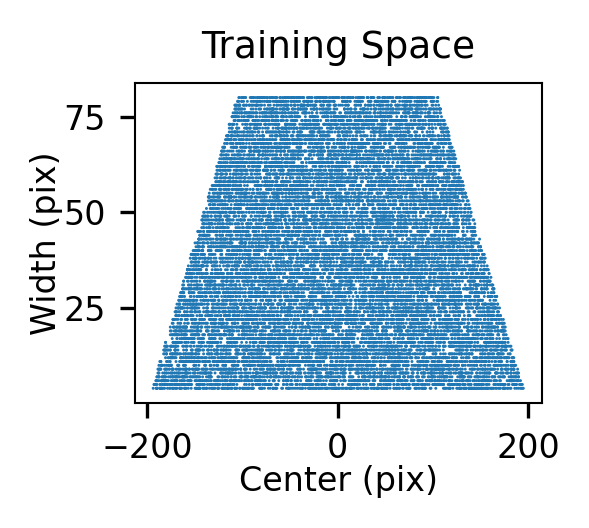

In [5]:
plt.figure(dpi=300, figsize=(2,1.8))
plt.scatter(peak_train_gauss.conditions_[::5,1], peak_train_gauss.conditions_[::5,2], s=0.5, facecolor='C0', edgecolor='None')
plt.xlabel('Center (pix)', fontdict={'size':8})
plt.ylabel('Width (pix)', fontdict={'size':8})
plt.title('Training Space', fontdict={'size':9})
plt.tight_layout()
plt.savefig('TrainingSpace.png', dpi=300)

## Instantiate Hilbert Transforms

In [6]:
methods = {'DHT': DHT, 'DHT-Pad': DHT_Pad, 'LeDHT': LeDHT}
parameters = {'DHT':{}, 'DHT-Pad':{'pad_factor':1}, 'LeDHT':{'regressor_inst':LinearRegression(fit_intercept=False, n_jobs=-1)}}
estimators = {m:methods[m](**parameters[m]) for m in methods}

## Training and Test Times for Estimators

In [7]:
print('Training times (N={})\n=========================='.format(X_train.shape))
for m in estimators:
    tmr = timer()
    estimators[m].fit(X_train,Y_train)
    tmr -= timer()
    print('{}: {} s'.format(m, -tmr))
    
print('\nPrediction times (N={}) with Training Data\n=========================='.format(X_train.shape))
for m in estimators:
    tmr = timer()
    estimators[m].predict(X_train)
    tmr -= timer()
    print('{}: {} s'.format(m, -tmr))

Training times (N=(300000, 401))
DHT: 1.9000144675374031e-06 s
DHT-Pad: 1.500011421740055e-06 s
LeDHT: 9.986791700008325 s

Prediction times (N=(300000, 401)) with Training Data
DHT: 12.09492159995716 s
DHT-Pad: 46.9627230000915 s
LeDHT: 0.9991651999298483 s


## Generate Test Set (No DC Offset, No Noise)

In [8]:
mse_results = {}
N_test_reps = 3  # Number of replicates

mse_results = {}
mse_results['center'] = []
mse_results['mse'] = []
mse_results['rep'] = []
mse_results['method'] = []
    
for m in estimators:
    print('-------------{}-------------'.format(m))
    for num in range(N_test_reps):
        print('Replicate: {}/{}'.format(num+1, N_test_reps))
        peak_test_gauss = GaussianTrainingData(n, stack_Hf_f=False,  amp=2.0, n_samples=N_test_samples, random_state=450 + num, 
                                               amp_reps=None, center=ctr_fcn, width=width_fcn, f_is_even=False)
        X_test = peak_test_gauss.f_
        Y_test = peak_test_gauss.Hf_
        
        for span in range(int(n.min()),int(n.max())+1):
            idxs = peak_test_gauss.conditions_[:,1] == span
            N_entries = idxs.sum()
            if N_entries > 0:
                mse_results['method'].extend(N_entries*[m])
                mse_results['center'].extend(N_entries*[span])
                mse_results['mse'].extend(mean_squared_error(Y_test[idxs,:].T, estimators[m].predict(X_test[idxs,:]).T, squared=True, multioutput='raw_values').tolist())
                mse_results['rep'].extend(N_entries*[num])
    print()
assert dict_keys_all_same_len(mse_results)

-------------DHT-------------
Replicate: 1/3
Replicate: 2/3
Replicate: 3/3

-------------DHT-Pad-------------
Replicate: 1/3
Replicate: 2/3
Replicate: 3/3

-------------LeDHT-------------
Replicate: 1/3
Replicate: 2/3
Replicate: 3/3



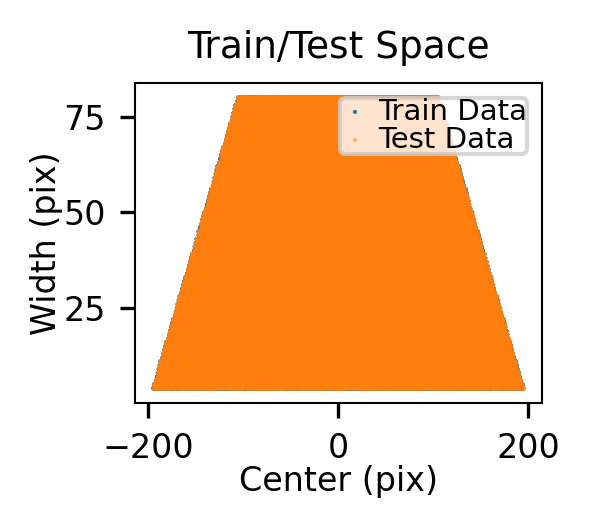

In [9]:
# Plot Train and Test Data Parameter Space
plt.figure(dpi=300, figsize=(2,1.8))
plt.scatter(peak_train_gauss.conditions_[::1,1], peak_train_gauss.conditions_[::1,2], s=1.0, edgecolor='none', label='Train Data')
plt.scatter(peak_test_gauss.conditions_[::1,1], peak_test_gauss.conditions_[::1,2], s=1.0, edgecolor='none', alpha=0.5, label='Test Data')
plt.xlabel('Center (pix)', fontdict={'size':8})
plt.ylabel('Width (pix)', fontdict={'size':8})
plt.title('Train/Test Space', fontdict={'size':9})
plt.tight_layout()

plt.legend(frameon=True)

-----------Window-Center Peak-----------
DHT MSE: 6.98e-02
DHT-Pad MSE: 1.28e-03
LeDHT MSE: 1.45e-09

-----------Window-Edge Peak-----------
DHT MSE: 1.01e-01
DHT-Pad MSE: 4.81e-02
LeDHT MSE: 8.67e-05


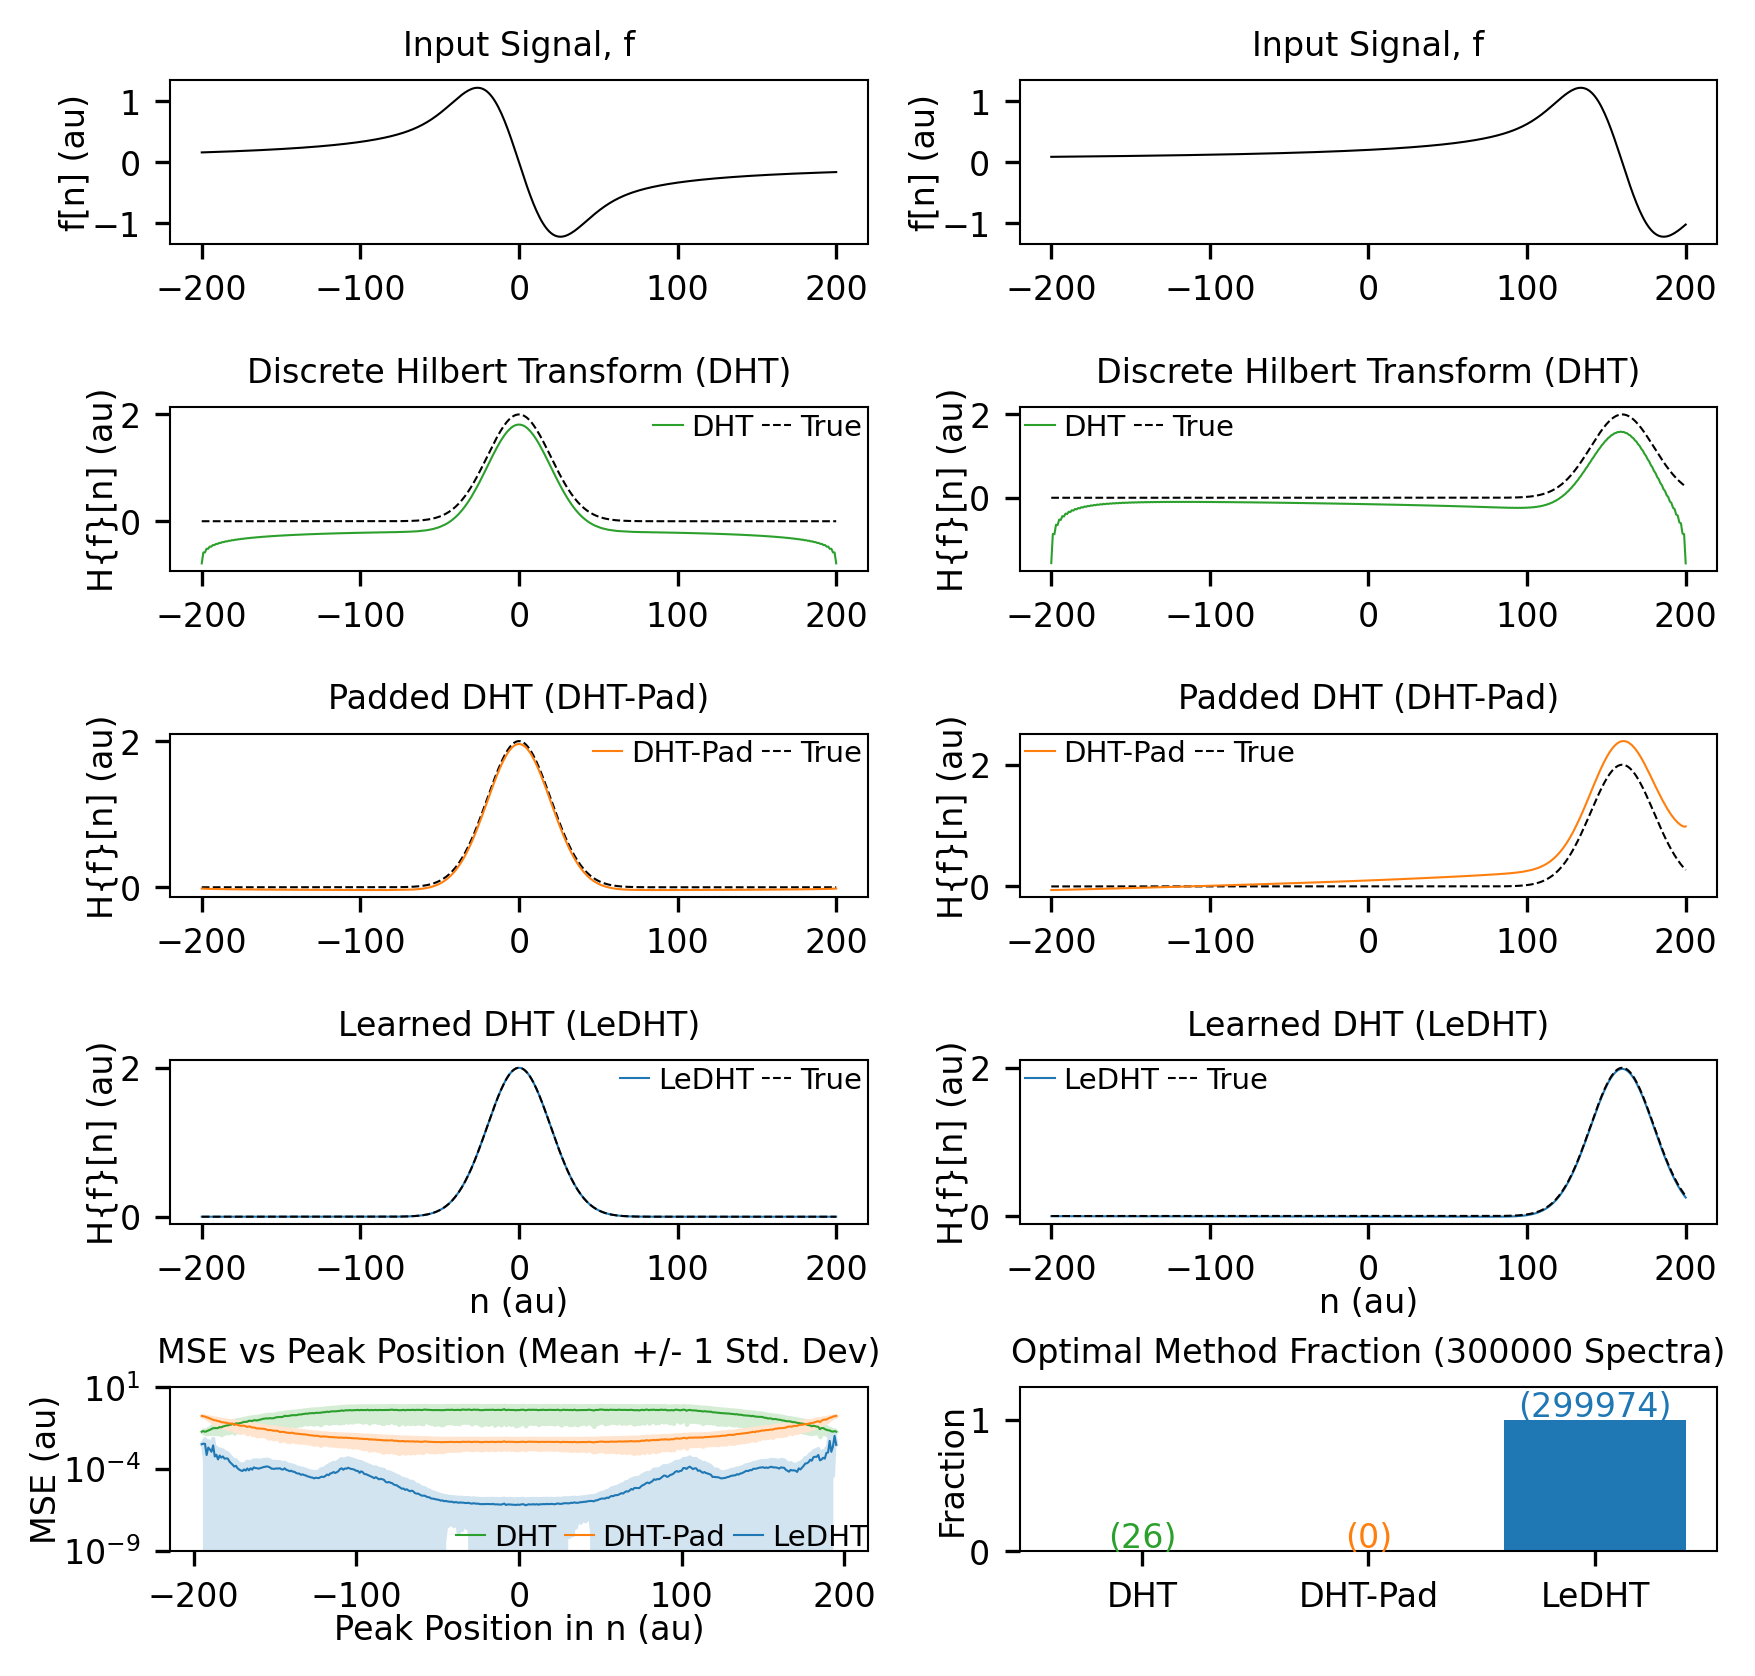

In [10]:
# Centered Dawson-Gaussian peak
temp_peaks = GaussianTrainingData(n, stack_Hf_f=False,  n_samples=1, amp=2.0, random_state=None, 
                                  amp_reps=None, center=0, width=int(.05*N), f_is_even=False)

fig = plt.figure(figsize=(5.75,5.5), dpi=300)
axs = []

axs.append(plt.subplot2grid((5,2), (0,0), fig=fig))
plt.plot(n, temp_peaks.f_.T, 'k')
plt.title('Input Signal, f', fontsize=8)
plt.ylabel('f[n] (au)')
# plt.text(-750, 0.65, '(a)')

###
# DHT
m = 'DHT'
axs.append(plt.subplot2grid((5,2), (1,0), fig=fig))
plt.title('Discrete Hilbert Transform (DHT)', fontsize=8)
plt.ylabel('H{f}[n] (au)')
c = color_palette[0]
ls = '-'
lw = 0.5
zo=2
plt.plot(n, estimators[m].predict(temp_peaks.f_).T, label=m, color=c, lw=lw, ls=ls, zorder=zo)
plt.plot(n, temp_peaks.Hf_.T, 'k--', label='True')
plt.legend(['DHT','True'], ncol=2, borderpad=-0.3)

##
# DHT-Pad
m = 'DHT-Pad'
axs.append(plt.subplot2grid((5,2), (2,0), fig=fig))
plt.title('Padded DHT (DHT-Pad)', fontsize=8)
plt.ylabel('H{f}[n] (au)')
ls = '-'
c = color_palette[1]
lw = 0.5
zo=3
plt.plot(n, estimators[m].predict(temp_peaks.f_).T, label=m, color=c, lw=lw, ls=ls, zorder=zo)
plt.plot(n, temp_peaks.Hf_.T, 'k--', label='True')
plt.legend(['DHT-Pad','True'], ncol=2, borderpad=-0.3)

##
# LeDHT
m = 'LeDHT'
axs.append(plt.subplot2grid((5,2), (3,0), fig=fig))
plt.title('Learned DHT (LeDHT)', fontsize=8)
plt.ylabel('H{f}[n] (au)')
plt.xlabel('n (au)')

c = color_palette[2]
ls = '-'
lw = 0.5
zo = 1
plt.plot(n, estimators[m].predict(temp_peaks.f_).T, label=m, color=c, lw=lw, ls=ls, zorder=zo)
plt.plot(n, temp_peaks.Hf_.T, 'k--', label='True')
plt.legend(['LeDHT','True'], ncol=2, borderpad=-0.3)

##
axs.append(plt.subplot2grid((5,2), (4,0), colspan=1, fig=fig))
temp_df = pd.DataFrame(mse_results)
temp_df['Log MSE'] = np.log10(temp_df['mse'])
# lp = sns.lineplot(x='center', y='Log MSE', hue='method', data=temp_df, ci='sd', palette=color_palette)
lp = sns.lineplot(x='center', y='mse', hue='method', data=temp_df, ci='sd', palette=color_palette)

# lp = sns.lineplot(x='center', y='mse', hue='method', data=mse_results, ci='sd', palette=color_palette)
for l in lp.collections:
    non_trans_rgba = 1*make_non_transparent(l.get_facecolor())
    l.set_edgecolor(non_trans_rgba)
    l.set_facecolor(non_trans_rgba)
    l.set_alpha(1.0)
    
plt.xlabel('Peak Position in n (au)')
plt.ylabel('MSE (au)')
txt = plt.title('MSE vs Peak Position (Mean +/- 1 Std. Dev)')
txt.set_in_layout(False)
plt.legend(['DHT','DHT-Pad','LeDHT'],loc='lower right', borderpad=-0.5, ncol=3)
plt.yscale('log')
plt.axis(ymin=1e-8)

print('-----------Window-Center Peak-----------')
for m in estimators:
    print('{} MSE: {:.2e}'.format(m, mean_squared_error(temp_peaks.Hf_, estimators[m].predict(temp_peaks.f_))))
print()
##################

# Window-Edge Dawson-Gaussian peak
temp_peaks = GaussianTrainingData(n, stack_Hf_f=False,  n_samples=1, amp=2.0, random_state=None, 
                                  amp_reps=None, center=int((0.8*N)//2), width=int(.05*N), f_is_even=False)
    
axs.append(plt.subplot2grid((5,2), (0,1), fig=fig))
plt.plot(n, temp_peaks.f_.T, 'k')
plt.title('Input Signal, f', fontsize=8)
plt.ylabel('f[n] (au)')

###
# DHT
m = 'DHT'
axs.append(plt.subplot2grid((5,2), (1,1), fig=fig))
plt.title('Discrete Hilbert Transform (DHT)', fontsize=8)
plt.ylabel('H{f}[n] (au)')
c = color_palette[0]
ls = '-'
lw = 0.5
zo=2
plt.plot(n, estimators[m].predict(temp_peaks.f_).T, label=m, color=c, lw=lw, ls=ls, zorder=zo)
plt.plot(n, temp_peaks.Hf_.T, 'k--', label='True')
plt.legend(['DHT','True'], ncol=2, borderpad=-0.3)

##
# DHT-Pad
m = 'DHT-Pad'
axs.append(plt.subplot2grid((5,2), (2,1), fig=fig))
plt.title('Padded DHT (DHT-Pad)', fontsize=8)
plt.ylabel('H{f}[n] (au)')
ls = '-'
c = color_palette[1]
lw = 0.5
zo=3
plt.plot(n, estimators[m].predict(temp_peaks.f_).T, label=m, color=c, lw=lw, ls=ls, zorder=zo)
plt.plot(n, temp_peaks.Hf_.T, 'k--', label='True')
plt.legend(['DHT-Pad','True'], ncol=2, borderpad=-0.3)

##
# LeDHT
m = 'LeDHT'
axs.append(plt.subplot2grid((5,2), (3,1), fig=fig))
plt.title('Learned DHT (LeDHT)', fontsize=8)
plt.ylabel('H{f}[n] (au)')
plt.xlabel('n (au)')

c = color_palette[2]
ls = '-'
lw = 0.5
zo = 1
plt.plot(n, estimators[m].predict(temp_peaks.f_).T, label=m, color=c, lw=lw, ls=ls, zorder=zo)
plt.plot(n, temp_peaks.Hf_.T, 'k--', label='True')
plt.legend(['LeDHT','True'], ncol=2, borderpad=-0.3)

##
axs.append(plt.subplot2grid((5,2), (4,1), colspan=1, fig=fig))
temp_mat = np.vstack((temp_df[temp_df['method'] == 'DHT']['mse'].values, temp_df[temp_df['method'] == 'DHT-Pad']['mse'].values, 
           temp_df[temp_df['method'] == 'LeDHT']['mse'].values))
plt.bar(0, (temp_mat.argmin(axis=0)==0).mean(), color=color_palette[0])
plt.bar(1, (temp_mat.argmin(axis=0)==1).mean(), color=color_palette[1])
plt.bar(2, (temp_mat.argmin(axis=0)==2).mean(), color=color_palette[2])
# plt.hist(temp_mat, bins=[-0.5,0.5,1.5,2.5], density=True)
plt.xticks([0,1,2],['DHT', 'DHT-Pad','LeDHT'])
plt.title('Optimal Method Fraction ({} Spectra)'.format(temp_df[temp_df['method'] == 'DHT']['mse'].size))
# plt.title('Lowest MSE Fraction ({} Spectra)'.format(temp_df[temp_df['method'] == 'DHT']['mse'].size))
plt.ylabel('Fraction')
plt.text(0, (temp_mat.argmin(axis=0)==0).mean()+0.03,'({})'.format((temp_mat.argmin(axis=0)==0).sum()), fontdict={'color':color_palette[0]}, ha='center')
plt.text(1,(temp_mat.argmin(axis=0)==1).mean()+0.03,'({})'.format((temp_mat.argmin(axis=0)==1).sum()), fontdict={'color':color_palette[1]}, ha='center')
plt.text(2, (temp_mat.argmin(axis=0)==2).mean()+0.03,'({})'.format((temp_mat.argmin(axis=0)==2).sum()), fontdict={'color':color_palette[2]}, ha='center')
plt.axis(ymax=1.25)


plt.sca(axs[4])
# txt = plt.text(-300, 100, '(e)')
# txt.set_in_layout(False)
plt.yticks([1e-9, 1e-4, 1e1])
plt.axis(ymin=1e-9, ymax=10)

plt.tight_layout(h_pad=0.5, w_pad=0.75, pad=0.5)

plt.savefig('Manuscript_Simulated_Sgl_Peaks.png')
# plt.savefig('Manuscript_Simulated_Sgl_Peaks.svg')


print('-----------Window-Edge Peak-----------')
for m in estimators:
    print('{} MSE: {:.2e}'.format(m, mean_squared_error(temp_peaks.Hf_, estimators[m].predict(temp_peaks.f_))))
plt.show()



## Synthetic Spectra Generator

In [11]:
mse_spectra_results = {}
N_spectra_reps = 3  # Number of replicates

mse_spectra_results = {}

mse_spectra_results['mse'] = []
mse_spectra_results['rep'] = []
mse_spectra_results['method'] = []
    
width_fcn_spectra = lambda: np.random.randint(width_min, width_max//3 + 1)

for m in estimators:
    for num in range(N_spectra_reps):
        synth_spectra = SyntheticSpectra(GaussianTrainingData(n, stack_Hf_f=False,  n_samples=10, amp=[1.0,2.0],
                                                              random_state=1025+num, 
                                                              amp_reps=None, center=ctr_fcn, width=width_fcn_spectra, f_is_even=False), 
                                         n_spectra=10000, n_peak_lims=[1,15])

        X_spectra = synth_spectra.f_
        Y_spectra = synth_spectra.Hf_
        
        N_entries = Y_spectra.shape[0]
        mse_spectra_results['method'].extend(N_entries*[m])
        mse_spectra_results['mse'].extend(mean_squared_error(Y_spectra.T, estimators[m].predict(X_spectra).T, squared=True, multioutput='raw_values').tolist())
        mse_spectra_results['rep'].extend(N_entries*[num])


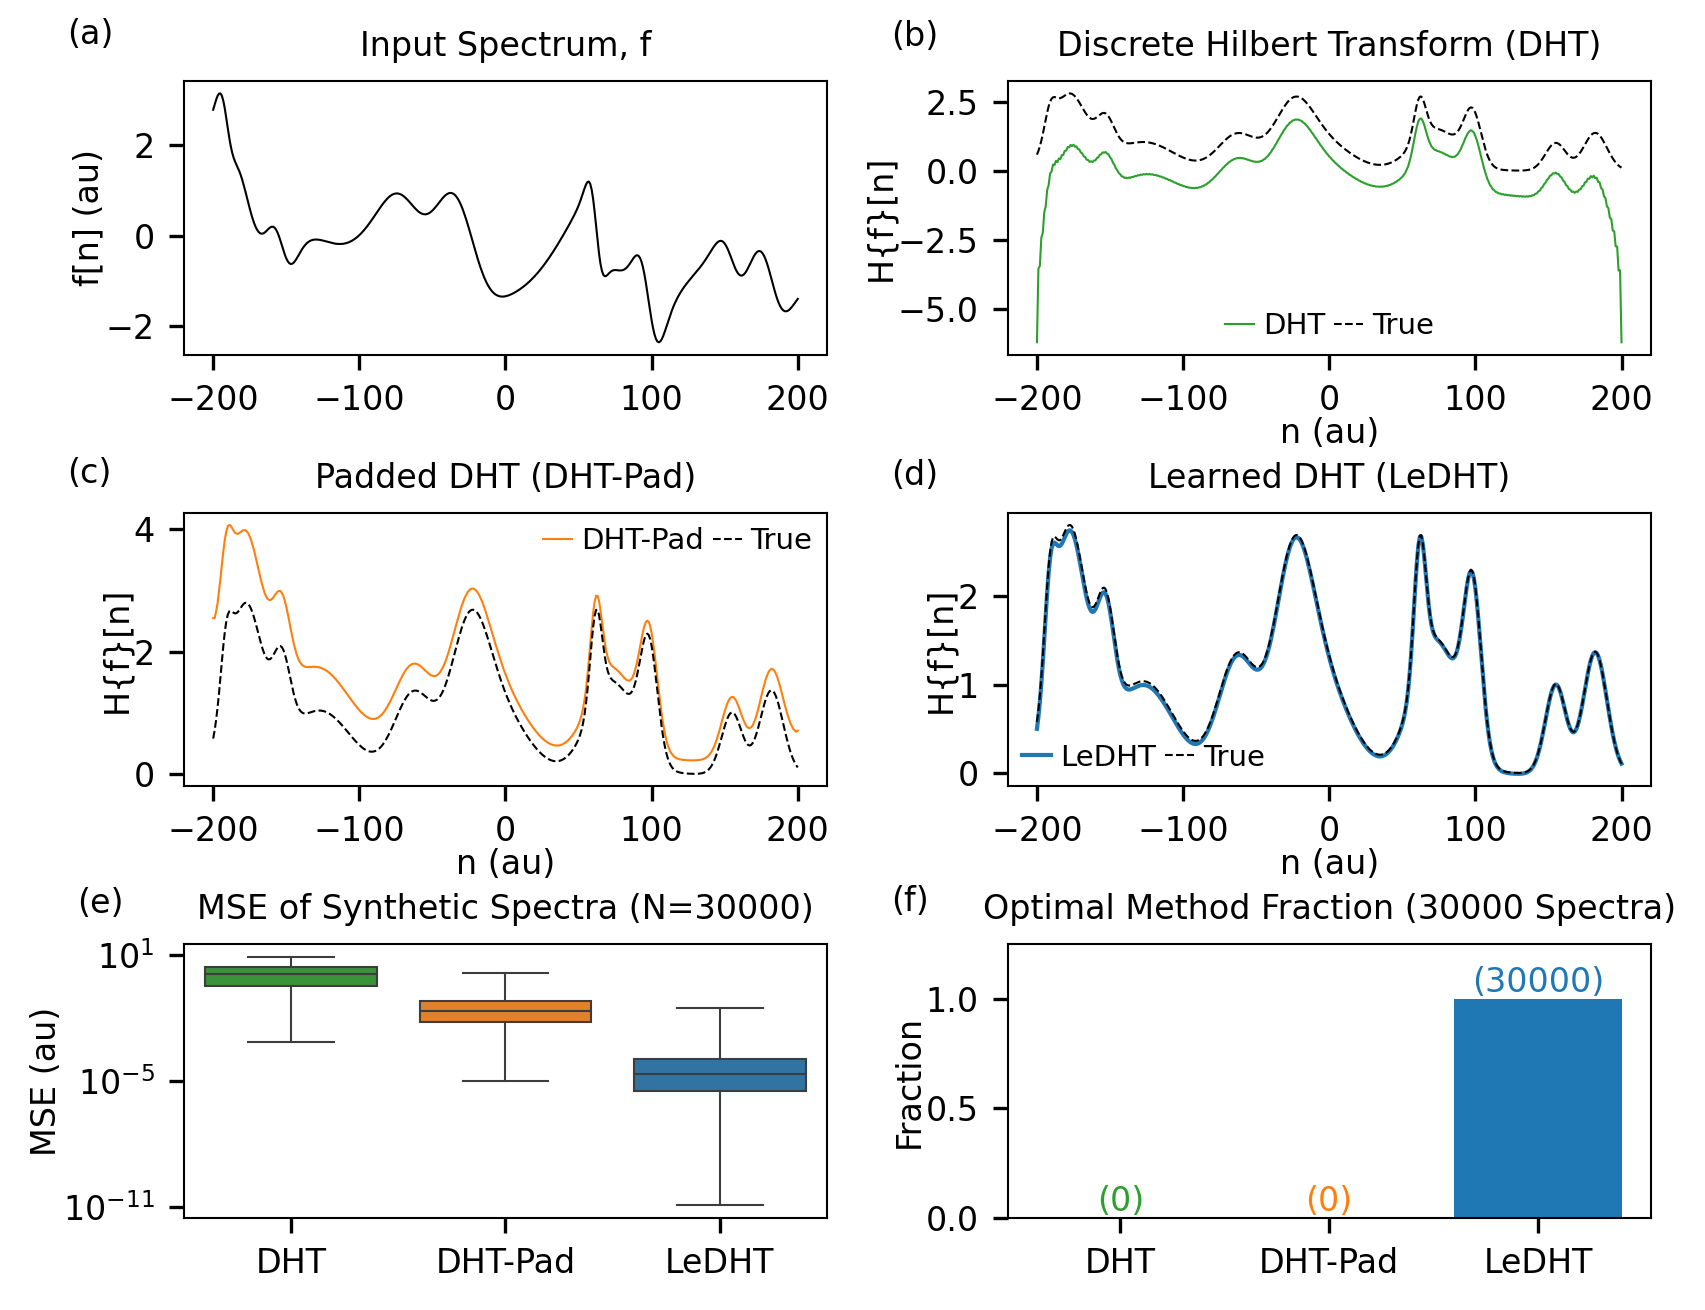

In [12]:
loc = 1  # Which spectra to plot. This was manually selected.

plt.figure(dpi=300, figsize=(5.75, 4.5))

plt.subplot2grid([3,2],[0,0])
plt.plot(n, X_spectra[loc],'k')
plt.title('Input Spectrum, f')
plt.ylabel('f[n] (au)')
plt.yticks([-2,0,2])
txt = plt.text(-300, 4.25, '(a)')
txt.set_in_layout(False)

####
plt.subplot2grid([3,2],[0,1])
plt.plot(n,estimators['DHT'].predict(X_spectra[loc:loc+1,:]).squeeze(),color=color_palette[0], label='DHT')
# plt.plot(n,estimators['DHT-Pad'].predict(X_spectra[loc:loc+1,:]).squeeze() - 
#          0*estimators['DHT-Pad'].predict(X_spectra[loc:loc+1,:]).squeeze().min() ,color=color_palette[1], label='DHT-Pad')
# plt.plot(n,estimators['LeDHT'].predict(X_spectra[loc:loc+1,:]).squeeze(),color=color_palette[2], label='LeDHT', lw=1)
plt.title('Discrete Hilbert Transform (DHT)')
plt.plot(n,Y_spectra[loc,:],'k--', label='True')
plt.xlabel('n (au)')
plt.ylabel('H{f}[n]')
plt.legend(['DHT','True'], loc='best', borderpad=0, ncol=2)
# plt.legend(['DHT','DHT-Pad','LeDHT'],loc='lower right', borderpad=-0.3)
txt = plt.text(-300, 4.5, '(b)')
txt.set_in_layout(False)

####
plt.subplot2grid([3,2],[1,0])
plt.plot(n,estimators['DHT-Pad'].predict(X_spectra[loc:loc+1,:]).squeeze() - 
         0*estimators['DHT-Pad'].predict(X_spectra[loc:loc+1,:]).squeeze().min() ,color=color_palette[1], label='DHT-Pad')
plt.title('Padded DHT (DHT-Pad)')
plt.plot(n,Y_spectra[loc,:],'k--', label='True')
plt.xlabel('n (au)')
plt.ylabel('H{f}[n]')
plt.legend(['DHT-Pad', 'True'], loc='best', borderpad=0, ncol=2)
# plt.legend(['DHT','DHT-Pad','LeDHT'],loc='lower right', borderpad=-0.3)
txt = plt.text(-300, 4.75, '(c)')
txt.set_in_layout(False)

####
plt.subplot2grid([3,2],[1,1])
plt.plot(n,estimators['LeDHT'].predict(X_spectra[loc:loc+1,:]).squeeze(),color=color_palette[2], label='LeDHT', lw=1)
plt.title('Learned DHT (LeDHT)')
plt.plot(n,Y_spectra[loc,:],'k--', label='True')
plt.xlabel('n (au)')
plt.ylabel('H{f}[n]')
plt.legend(['LeDHT','True'], loc='best', borderpad=0, ncol=2)
# plt.legend(['DHT','DHT-Pad','LeDHT'],loc='lower right', borderpad=-0.3)
txt = plt.text(-300, 3.25, '(d)')
txt.set_in_layout(False)

##
plt.subplot2grid([3,2],[2,0])
temp_df = pd.DataFrame(mse_spectra_results)
temp_df['Log MSE'] = np.log10(temp_df['mse'])
# sns.boxplot(x='method', y='mse', data=mse_spectra_results, whis=[0,100], palette=[cm(0.3), cm(0.6), cm(0.9)])
# sns.violinplot(x='method', y='mse', data=temp_df, scale='count', inner='quartile', palette=color_palette)
sns.boxplot(x='method', y='mse', data=temp_df, whis=[0,100], palette=color_palette)
# sns.boxplot(x='method', y='Log MSE', data=temp_df, palette=color_palette, whis=[0,100])
# plt.xlabel('Range of Center Position of Spectral Peak')
plt.ylabel('MSE (au)')
plt.yscale('log')
plt.title('MSE of Synthetic Spectra (N={})'.format((temp_df['method']=='DHT').sum()))
# plt.legend()
txt = plt.text(-1, 1e3, '(e)')
txt.set_in_layout(False)
plt.yticks([1e-11, 1e-5, 1e1])
# plt.yticks([-10, -8, -6, -4, -2, 0])
plt.xlabel('')
plt.xticks([0,1,2],['DHT', 'DHT-Pad','LeDHT'])

###
plt.subplot2grid([3,2],[2,1])
temp_mat = np.vstack((temp_df[temp_df['method'] == 'DHT']['mse'].values, temp_df[temp_df['method'] == 'DHT-Pad']['mse'].values, 
           temp_df[temp_df['method'] == 'LeDHT']['mse'].values)).argmin(axis=0)
plt.bar(0, (temp_mat==0).mean(), color=color_palette[0])
plt.bar(1, (temp_mat==1).mean(), color=color_palette[1])
plt.bar(2, (temp_mat==2).mean(), color=color_palette[2])
# plt.hist(temp_mat, bins=[-0.5,0.5,1.5,2.5], density=True)
txt = plt.text(-1.1, 1.4, '(f)')
txt.set_in_layout(False)

plt.xticks([0,1,2],['DHT', 'DHT-Pad','LeDHT'])
plt.title('Optimal Method Fraction ({} Spectra)'.format(temp_df[temp_df['method'] == 'DHT']['mse'].size))
plt.ylabel('Fraction')
txt = plt.text(0,(temp_mat==0).mean()+0.03,'({})'.format((temp_mat==0).sum()), fontdict={'color':color_palette[0]}, ha='center')
txt.set_in_layout(False)
txt = plt.text(1,(temp_mat==1).mean()+0.03,'({})'.format((temp_mat==1).sum()), fontdict={'color':color_palette[1]}, ha='center')
txt.set_in_layout(False)
txt = plt.text(2,(temp_mat==2).mean()+0.03,'({})'.format((temp_mat==2).sum()), fontdict={'color':color_palette[2]}, ha='center')
txt.set_in_layout(False)
plt.axis(ymax=1.25)

plt.tight_layout(pad=1.5, h_pad=0.35, w_pad=1)

plt.savefig('Manuscript_Synth_Spectra.png')
plt.show()

# Experimental Data

In [13]:
filename = 'Glycerol_Coverslip_XZ.h5'
dset_hsi = 'BCARSImage/Glycerol_Coverslip_XZ_0/Glycerol_Coverslip_XZ_0'
dset_dark = 'BCARSImage/Glycerol_Coverslip_XZ_0/Dark_Post_0'

N_exp = 1600  # Spectral units for data import
n_exp = np.arange(N_exp)
temp_wavelength_vec = 1.65955456e-01 * n_exp + 5.687e+02
wn = 0.01 / (temp_wavelength_vec*1e-9) - 0.01/771.461e-9
del temp_wavelength_vec

In [14]:
# Glycerol
with h5.File(filename,'r') as fid:
    glyc = fid[dset_hsi][40,3:,:].mean(axis=0)
    
# Coverslip
with h5.File(filename,'r') as fid:
    cs = fid[dset_hsi][70,3:,:].mean(axis=0)
    
# Dark
with h5.File(filename,'r') as fid:
    dark_baseline = fid[dset_dark][...].reshape((-1,1600))[np.argsort(fid[dset_dark][...].reshape((-1,1600)).sum(axis=-1))[:250],:].mean(axis=0)

ratio = (glyc - dark_baseline)/(cs - dark_baseline)

## Compare Hilbert Transforms at Variable Spectral Window Widths

In [15]:
N_train_exp = 150000  # Number of training datasets to generate
parameters_exp = {'DHT':{}, 'DHT-Pad':{'pad_factor':1}, 'LeDHT':{'regressor_inst':LinearRegression(fit_intercept=False, n_jobs=-1)}}
estimators_exp = {m:methods[m](**parameters_exp[m]) for m in methods}

amps = [1.0]

# We are using a sub-region of each spectrum, i.e., we're only using the CH-/OH-stretch region.
starter = 0
ender = 460

# Peaks selected from A. Mudalige and J. E. Pemberton, "Raman spectroscopy of glycerol/D2O solutions," Vib. Spectrosc. 45(1), 27–35 (2007).

results = {'starter':[], 'ender':[], 'method':[], 'wn':[], 
           'phi':[], 'ratio':[], 'phi_2887':[], 'phi_2949':[], 'phi_3400':[],
           'Raman':[], 'Raman_2887':[], 'Raman_2949':[], 'Raman_3400':[]}

amps = [1.0]

# Run Hilbert transforms over smaller and smaller spectral ranges
for starter in range(0,230,10):
    print('Starter: {}'.format(starter))
    print('[{},{}] pixels. Bandwidth: {:.0f} cm-1\n'.format(starter, ender, wn[starter] - wn[ender]))
    
    peak_train_exp = GaussianTrainingData(np.arange(ender-starter), stack_Hf_f=False,  n_samples=N_train_exp, random_state=0, 
                                      amp_reps=amps, center=None, width=[3,50], f_is_even=False)

    X_exp = peak_train_exp.f_
    Y_exp = peak_train_exp.Hf_

    copy_multi_exp = 3
    X_exp = np.repeat(X_exp, copy_multi_exp, axis=0)
    Y_exp = np.repeat(Y_exp, copy_multi_exp, axis=0)

    noise_exp = 1e-2*np.random.randn(X_exp.shape[0], ender - starter)
    X_exp += noise_exp
    Y_exp += hilbert(noise_exp)

    dc_offset_exp = np.random.randn(X_exp.shape[0],1) @ np.ones((1,ender-starter)) 
    X_exp += dc_offset_exp
    
    for m in estimators_exp:
#         print('------------{}------------'.format(m))
        estimators_exp[m].fit(X_exp, Y_exp)
    
        results['starter'].append(1*starter)
        results['ender'].append(1*ender)
        results['method'].append(m)
        
        temp = hilbert(-0.5*np.log(ratio[starter:ender]))
        
        results['ratio'].append(ratio[starter:ender])
        results['phi'].append(np.squeeze(estimators_exp[m].predict(-0.5*np.log(results['ratio'][-1])[None,:])))
        results['Raman'].append(np.sqrt(results['ratio'][-1]) * np.sin(results['phi'][-1]))
        results['wn'].append(wn[starter:ender])
        
        loc = find_nearest(wn[starter:ender], 2887)[1]
        results['phi_2887'].append(results['phi'][-1][loc])
        results['Raman_2887'].append(results['Raman'][-1][loc])
        
        loc = find_nearest(wn[starter:ender], 2949)[1]
        results['phi_2949'].append(results['phi'][-1][loc])
        results['Raman_2949'].append(results['Raman'][-1][loc])
        
        loc = find_nearest(wn[starter:ender], 3400)[1]
        results['phi_3400'].append(results['phi'][-1][loc])
        results['Raman_3400'].append(results['Raman'][-1][loc])
        

Starter: 0
[0,460] pixels. Bandwidth: 2081 cm-1

Starter: 10
[10,460] pixels. Bandwidth: 2030 cm-1

Starter: 20
[20,460] pixels. Bandwidth: 1979 cm-1

Starter: 30
[30,460] pixels. Bandwidth: 1928 cm-1

Starter: 40
[40,460] pixels. Bandwidth: 1878 cm-1

Starter: 50
[50,460] pixels. Bandwidth: 1828 cm-1

Starter: 60
[60,460] pixels. Bandwidth: 1778 cm-1

Starter: 70
[70,460] pixels. Bandwidth: 1729 cm-1

Starter: 80
[80,460] pixels. Bandwidth: 1680 cm-1

Starter: 90
[90,460] pixels. Bandwidth: 1631 cm-1

Starter: 100
[100,460] pixels. Bandwidth: 1582 cm-1

Starter: 110
[110,460] pixels. Bandwidth: 1534 cm-1

Starter: 120
[120,460] pixels. Bandwidth: 1486 cm-1

Starter: 130
[130,460] pixels. Bandwidth: 1438 cm-1

Starter: 140
[140,460] pixels. Bandwidth: 1391 cm-1

Starter: 150
[150,460] pixels. Bandwidth: 1344 cm-1

Starter: 160
[160,460] pixels. Bandwidth: 1297 cm-1

Starter: 170
[170,460] pixels. Bandwidth: 1250 cm-1

Starter: 180
[180,460] pixels. Bandwidth: 1204 cm-1

Starter: 190
[1

## Raman + Phase

N.B.: **Various annotations in the published manuscript were added in post-processing and will not be seen in the figure below**

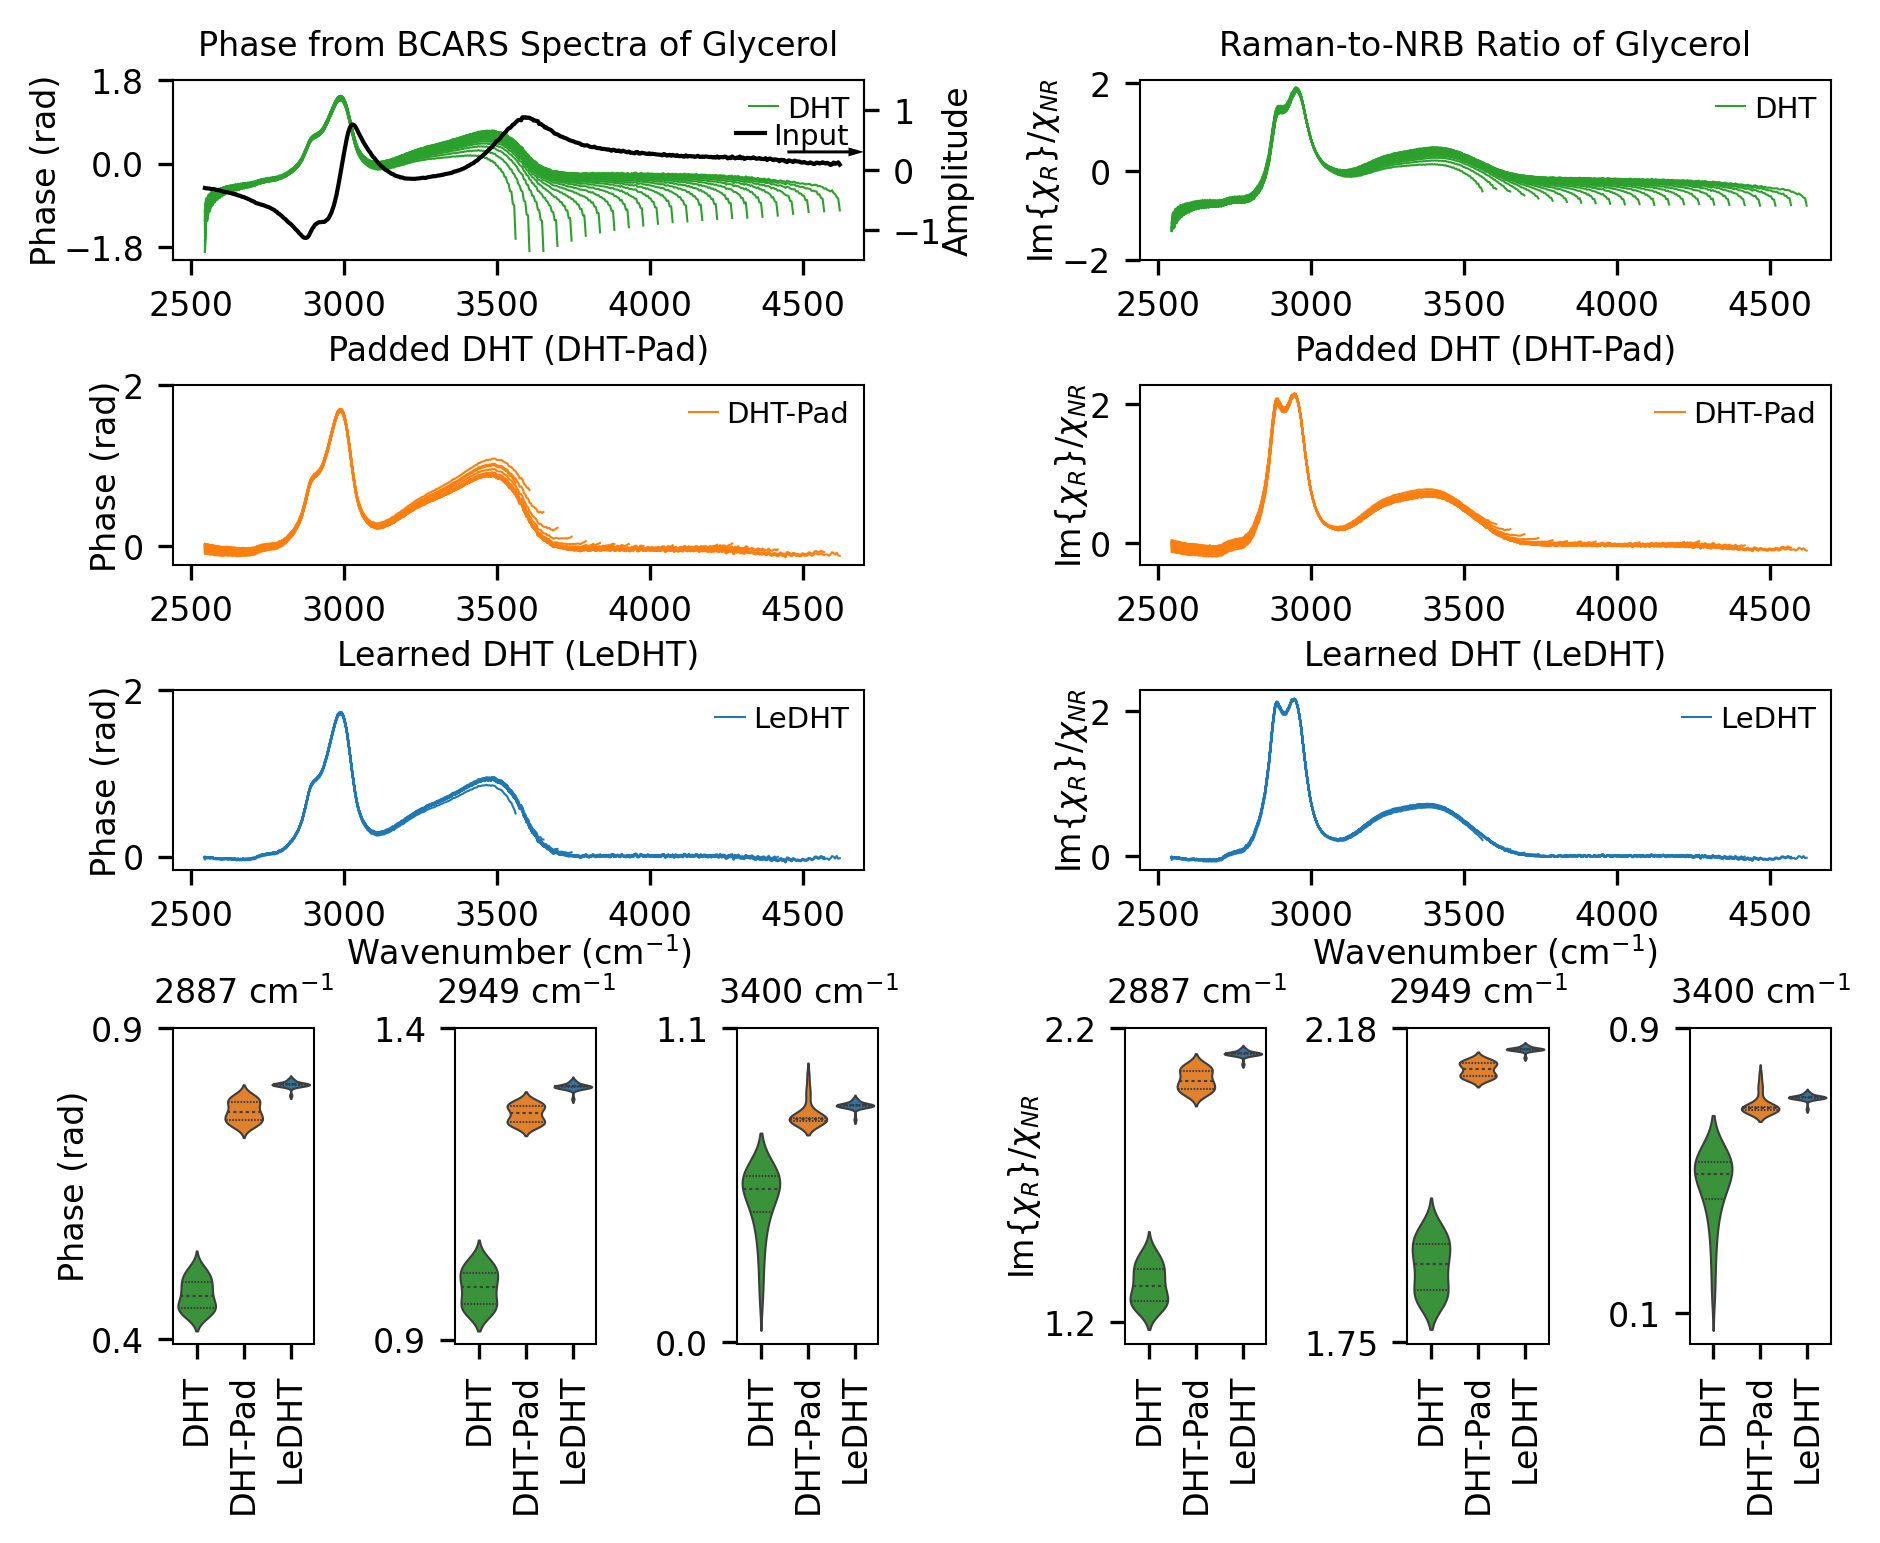

In [16]:
fig = plt.figure(figsize=(6.5, 5.2))

gs0 = gridspec.GridSpec(3, 2, figure=fig, hspace=0.5, wspace=0.35, left=0.1, right=0.95, top=0.93, bottom=0.12)
            
gs00 = gridspec.GridSpecFromSubplotSpec(3, 2, subplot_spec=gs0[0:2,:], wspace=0.4, hspace=0.7)

ax00 = fig.add_subplot(gs00[0, 0])
ax10 = fig.add_subplot(gs00[1, 0])
ax20 = fig.add_subplot(gs00[2, 0])

ax01 = fig.add_subplot(gs00[0, 1])
ax11 = fig.add_subplot(gs00[1, 1])
ax21 = fig.add_subplot(gs00[2, 1])

# the following syntax does the same as the GridSpecFromSubplotSpec call above:
gs01 = gs0[2,0].subgridspec(1, 3, wspace=1)
ax_sub0_00 = fig.add_subplot(gs01[0, 0])
ax_sub0_01 = fig.add_subplot(gs01[0, 1])
ax_sub0_02 = fig.add_subplot(gs01[0, 2])

gs02 = gs0[2,1].subgridspec(1, 3, wspace=1)
ax_sub1_00 = fig.add_subplot(gs02[0, 0])
ax_sub1_01 = fig.add_subplot(gs02[0, 1])
ax_sub1_02 = fig.add_subplot(gs02[0, 2])
###########################################################
#############################################################

temp_df = pd.DataFrame(results)

###############################
plt.sca(ax00)
dht_labeled = False
dht_pad_labeled = False
ledht_labeled = False
for num, q in enumerate(temp_df.iterrows()):
    m = q[1]['method']
    if m != 'DHT':
        continue
    if m == 'DHT':
        c = color_palette[0]
        if not dht_labeled:
            dht_labeled = True
            label = m
        else:
            label = None
    elif m == 'DHT-Pad':
        c = color_palette[1]
        if not dht_pad_labeled:
            dht_pad_labeled = True
            label = m
        else:
            label = None
    else:
        c = color_palette[2]
        if not ledht_labeled:
            ledht_labeled = True
            label = m
        else:
            label = None
    plt.plot(wn[q[1]['starter']:q[1]['ender']], q[1]['phi'], label=label, color=c)
plt.title('Phase from BCARS Spectra of Glycerol')
plt.ylabel('Phase (rad)')
# plt.legend(['DHT','DHT-Pad','LeDHT'], ncol=2, loc='lower center')
plt.legend(['DHT'], ncol=2, loc='upper right')
plt.yticks([-1.8,0,1.8])
# plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.axis(xmax=4700)
# plt.text(2000,2.5,'(a)')
plt.twinx()
plt.plot(wn[:ender], -0.5*np.log(ratio[:ender]), 'k', lw=1, label='Input')
plt.axis(ymin=-1.5, ymax=1.5)
plt.legend(loc='upper right', bbox_to_anchor=(0.0, 0., 1.0, 0.85))
plt.ylabel('Amplitude')
plt.arrow(4450, 0.3, 250, 0, length_includes_head=True, head_length=50, width=0.05, facecolor='k', edgecolor='none')


##
plt.sca(ax10)
dht_labeled = False
dht_pad_labeled = False
ledht_labeled = False
for num, q in enumerate(temp_df.iterrows()):
    m = q[1]['method']
    if m != 'DHT-Pad':
        continue
    if m == 'DHT':
        c = color_palette[0]
        if not dht_labeled:
            dht_labeled = True
            label = m
        else:
            label = None
    elif m == 'DHT-Pad':
        c = color_palette[1]
        if not dht_pad_labeled:
            dht_pad_labeled = True
            label = m
        else:
            label = None
    else:
        c = color_palette[2]
        if not ledht_labeled:
            ledht_labeled = True
            label = m
        else:
            label = None
    plt.plot(wn[q[1]['starter']:q[1]['ender']], q[1]['phi'], label=label, color=c)
plt.title('Padded DHT (DHT-Pad)')
plt.ylabel('Phase (rad)')

plt.legend(['DHT-Pad'], ncol=2, loc='upper right')
plt.yticks([0,2])
plt.axis(xmax=4700)

##
plt.sca(ax20)
dht_labeled = False
dht_pad_labeled = False
ledht_labeled = False
for num, q in enumerate(temp_df.iterrows()):
    m = q[1]['method']
    if m != 'LeDHT':
        continue
    if m == 'DHT':
        c = color_palette[0]
        if not dht_labeled:
            dht_labeled = True
            label = m
        else:
            label = None
    elif m == 'DHT-Pad':
        c = color_palette[1]
        if not dht_pad_labeled:
            dht_pad_labeled = True
            label = m
        else:
            label = None
    else:
        c = color_palette[2]
        if not ledht_labeled:
            ledht_labeled = True
            label = m
        else:
            label = None
    plt.plot(wn[q[1]['starter']:q[1]['ender']], q[1]['phi'], label=label, color=c)
plt.title('Learned DHT (LeDHT)')
plt.ylabel('Phase (rad)')
# plt.legend(['DHT','DHT-Pad','LeDHT'], ncol=2, loc='lower center')
plt.legend(['LeDHT'], ncol=2, loc='upper right')
plt.yticks([0,2])
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.axis(xmax=4700)

###############################
plt.sca(ax01)
dht_labeled = False
dht_pad_labeled = False
ledht_labeled = False
for num, q in enumerate(temp_df.iterrows()):
    m = q[1]['method']
    if m != 'DHT':
        continue
    if m == 'DHT':
        c = color_palette[0]
        if not dht_labeled:
            dht_labeled = True
            label = m
        else:
            label = None
    elif m == 'DHT-Pad':
        c = color_palette[1]
        if not dht_pad_labeled:
            dht_pad_labeled = True
            label = m
        else:
            label = None
    else:
        c = color_palette[2]
        if not ledht_labeled:
            ledht_labeled = True
            label = m
        else:
            label = None
    plt.plot(wn[q[1]['starter']:q[1]['ender']], q[1]['Raman'], label=label, color=c)
plt.title('Raman-to-NRB Ratio of Glycerol')
plt.ylabel('Im$\{\chi_R\} / \chi_{NR}$')
# plt.legend(['DHT','DHT-Pad','LeDHT'], ncol=2, loc='lower center')
plt.legend(['DHT'], ncol=2, loc='upper right')
plt.yticks([-2,0,2])
plt.axis(xmax=4700)

##
plt.sca(ax11)
dht_labeled = False
dht_pad_labeled = False
ledht_labeled = False
for num, q in enumerate(temp_df.iterrows()):
    m = q[1]['method']
    if m != 'DHT-Pad':
        continue
    if m == 'DHT':
        c = color_palette[0]
        if not dht_labeled:
            dht_labeled = True
            label = m
        else:
            label = None
    elif m == 'DHT-Pad':
        c = color_palette[1]
        if not dht_pad_labeled:
            dht_pad_labeled = True
            label = m
        else:
            label = None
    else:
        c = color_palette[2]
        if not ledht_labeled:
            ledht_labeled = True
            label = m
        else:
            label = None
    plt.plot(wn[q[1]['starter']:q[1]['ender']], q[1]['Raman'], label=label, color=c)
plt.title('Padded DHT (DHT-Pad)')
plt.ylabel('Im$\{\chi_R\} / \chi_{NR}$')
# plt.legend(['DHT','DHT-Pad','LeDHT'], ncol=2, loc='lower center')
plt.legend(['DHT-Pad'], ncol=2, loc='upper right')
plt.yticks([0,2])
# plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.axis(xmax=4700)
# plt.text(2000,2.5,'(a)')
# plt.twinx()
# plt.plot(wn[:ender], -0.5*np.log(ratio[:ender]), 'k', lw=1, label='Input')
# plt.axis(ymin=-1.5, ymax=1.5)
# plt.legend(loc='upper right')
# plt.ylabel('Amplitude')
# plt.arrow(4280, 0.35, 400, 0, length_includes_head=True, head_length=50, width=0.05, facecolor='k', edgecolor='none')

##
plt.sca(ax21)
dht_labeled = False
dht_pad_labeled = False
ledht_labeled = False
for num, q in enumerate(temp_df.iterrows()):
    m = q[1]['method']
    if m != 'LeDHT':
        continue
    if m == 'DHT':
        c = color_palette[0]
        if not dht_labeled:
            dht_labeled = True
            label = m
        else:
            label = None
    elif m == 'DHT-Pad':
        c = color_palette[1]
        if not dht_pad_labeled:
            dht_pad_labeled = True
            label = m
        else:
            label = None
    else:
        c = color_palette[2]
        if not ledht_labeled:
            ledht_labeled = True
            label = m
        else:
            label = None
    plt.plot(wn[q[1]['starter']:q[1]['ender']], q[1]['Raman'], label=label, color=c)
plt.title('Learned DHT (LeDHT)')
plt.ylabel('Im$\{\chi_R\} / \chi_{NR}$')
# plt.legend(['DHT','DHT-Pad','LeDHT'], ncol=2, loc='lower center')
plt.legend(['LeDHT'], ncol=2, loc='upper right')
plt.yticks([0,2])
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.axis(xmax=4700)
# plt.text(2000,2.5,'(a)')
# plt.twinx()
# plt.plot(wn[:ender], -0.5*np.log(ratio[:ender]), 'k', lw=1, label='Input')
# plt.axis(ymin=-1.5, ymax=1.5)
# plt.legend(loc='upper right')
# plt.ylabel('Amplitude')
# plt.arrow(4280, 0.35, 400, 0, length_includes_head=True, head_length=50, width=0.05, facecolor='k', edgecolor='none')


#######################################
plt.sca(ax_sub0_00)
sns.violinplot(x='method', y='phi_2887', data=temp_df, scale='count', inner='quartile', palette=color_palette)
plt.xticks([0,1,2],['DHT','DHT-Pad','LeDHT'], rotation=90)
plt.xlabel('')
plt.ylabel('Phase (rad)')
# plt.yticks([0.5,0.75,1.0])
q = np.round(np.array(plt.axis())[2:]+0.05,1)
plt.yticks([q[0], q[1]])
plt.title('2887 cm$^{-1}$')
# txt = plt.text(-3.2,1.11,'(c)')
txt.set_in_layout(False)

plt.sca(ax_sub0_01)
sns.violinplot(x='method', y='phi_2949', data=temp_df, scale='count', inner='quartile', palette=color_palette)
plt.xticks([0,1,2],['DHT','DHT-Pad','LeDHT'], rotation=90)
# plt.yticks([1.25,1.5,1.75])
q = np.round(np.array(plt.axis())[2:]+0.05,1)
plt.yticks([q[0], q[1]])
plt.xlabel('')
plt.ylabel('')
plt.title('2949 cm$^{-1}$')
# txt = plt.text(-2.5,1.875,'(d)')
txt.set_in_layout(False)

plt.sca(ax_sub0_02)
sns.violinplot(x='method', y='phi_3400', data=temp_df, scale='count', inner='quartile', palette=color_palette)
plt.xticks([0,1,2],['DHT','DHT-Pad','LeDHT'], rotation=90)
plt.xlabel('')
plt.ylabel('')
# plt.yticks([0,0.6,1.2])
q = np.round(np.array(plt.axis())[2:]+0.05,1)
plt.yticks([q[0], q[1]])
plt.title('3400 cm$^{-1}$')
# txt = plt.text(-2.5,1.47,'(e)')
txt.set_in_layout(False)

plt.sca(ax_sub1_00)
sns.violinplot(x='method', y='Raman_2887', data=temp_df, scale='count', inner='quartile', palette=color_palette)
plt.xticks([0,1,2],['DHT','DHT-Pad','LeDHT'], rotation=90)
plt.xlabel('')
plt.ylabel('Im$\{\chi_R\} / \chi_{NR}$')
# plt.yticks([1.25, 1.5, 1.75, 2.0])
q = np.round(np.array(plt.axis())[2:]+0.05,1)
plt.yticks([q[0], q[1]])
plt.title('2887 cm$^{-1}$')
# txt = plt.text(-3.2,2.2,'(h)')
txt.set_in_layout(False)

plt.sca(ax_sub1_01)
sns.violinplot(x='method', y='Raman_2949', data=temp_df, scale='count', inner='quartile', palette=color_palette)
plt.xticks([0,1,2],['DHT','DHT-Pad','LeDHT'], rotation=90)
# plt.yticks([1.75, 2.2])
q = np.round(np.array(plt.axis())[2:]+0.005,2)
plt.yticks([q[0], q[1]])
plt.xlabel('')
plt.ylabel('')
plt.title('2949 cm$^{-1}$')
# txt = plt.text(-2.5,1.088,'(i)')
txt.set_in_layout(False)

plt.sca(ax_sub1_02)
sns.violinplot(x='method', y='Raman_3400', data=temp_df, scale='count', inner='quartile', palette=color_palette)
plt.xticks([0,1,2],['DHT','DHT-Pad','LeDHT'], rotation=90)
plt.xlabel('')
plt.ylabel('')
# plt.yticks([0, 0.5, 1.0])
q = np.round(np.array(plt.axis())[2:]+0.05,1)
plt.yticks([q[0], q[1]])

plt.title('3400 cm$^{-1}$')
# txt = plt.text(-2.5,0.9,'(j)')
txt.set_in_layout(False)

plt.savefig('Manuscript_Experiment_Both.png')

# Thumbnail

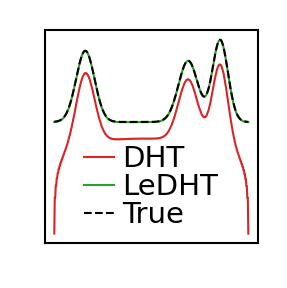

In [136]:
plt.figure(figsize=(1,1), dpi=300)
loc = 0

plt.plot(estimators['DHT'].predict(X_spectra[loc,:]),label='DHT', color='C3')
plt.plot(estimators['LeDHT'].predict(X_spectra[loc,:]),label='LeDHT', color='C2')
plt.plot(Y_spectra[loc,:],'k--', label='True')
plt.xticks([],'')
plt.yticks([],'')
plt.legend(fontsize=7)
plt.tight_layout()
plt.savefig('Thumbnail.jpg', pil_kwargs={'quality': 100})
plt.show()
